<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os
import time
import copy
import math
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

!pip install -qU focal_loss_torch
from focal_loss.focal_loss import FocalLoss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'fmri-dementia-resnet18-sweep-1')

In [ ]:
# Connecting to local runtime:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

# Import data

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path = "/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia"

labels = pd.read_csv(os.path.join(data_path, 'labels_new.csv'))

# Base Model

## Split train/val

In [ ]:
# labels_train, labels_val = train_test_split(labels, test_size = 0.2,
#                                             shuffle = True, random_state = 42,
#                                             stratify = labels['label'])

# labels_train.to_csv(os.path.join(data_path, 'labels_train.csv'), header = True)

# labels_val.to_csv(os.path.join(data_path, 'labels_val.csv'), header = True)

## Create dataloader

In [ ]:
class FMRILoader(Dataset):
    """
    fMRI Dataset Loader

    Args:
        path (str):
            Path to the CSV file

        labels (dict):
            Labels dictionnary if not provided by the CSV file

            AD: Alzheimer's disease
            FTD: Frontotemporal dementia
            HC: Healthy control
            MCI: Mild cognitive impairment
    """

    def __init__(self, path:str, labels:dict = {1:'AD', 2:'FTD', 3:'HC', 4:'MCI'}):
        self.folder = os.path.dirname(path)
        self.df = pd.read_csv(path)
        idname = dict()
        if 'class_name' in self.df:
            for i, row in self.df.iterrows():
                idname[row['label']] = row['class_name']
        else:
            idname = labels
        self.idclass = dict()
        for i, id in enumerate(set(idname)):
            self.idclass[id] = i
        self.classes = []
        for id in self.idclass:
            self.classes.append(idname[id])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns:
            A multichannel signal tensor and class id.
        """
        matrix_path = self.df['matrix'][idx]
        id = self.df['label'][idx]
        data = pd.read_csv(self.folder + '/data_dir/' + matrix_path, header = None).to_numpy()
        data = np.stack((data,)*3, axis = 0)
        data = data[:3, :200, :140]

        tensor = torch.tensor(data, dtype = torch.float32)



        return tensor, self.idclass[id]

In [ ]:
train_dataset = FMRILoader("/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/labels_train.csv")
val_dataset = FMRILoader("/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/labels_val.csv")

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

## ResNet18 model

Focal loss source: https://github.com/mathiaszinnen/focal_loss_torch

ROC-AUC score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 4),
    nn.Softmax(dim = -1)
    )

model = model.to(device)

In [ ]:
class_num = labels['label'].value_counts().sort_index()
class_weights = (class_num.max() / class_num).values
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = FocalLoss(gamma = 2, weights = class_weights)
optimizer = torch.optim.Adam(model.fc.parameters())

## Train model

In [ ]:
train_losses = []
train_accuracies = []
train_f1s = []
train_aucs = []

val_losses = []
val_accuracies = []
val_f1s = []
val_aucs = []

def train_model(model, criterion, optimizer, num_epochs = 3):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                dataset = train_dataset
                dataloader = train_loader
            else:
                model.eval()
                dataset = val_dataset
                dataloader = val_loader

            running_loss = 0.0
            running_outputs = torch.empty(0).cuda()
            running_labels = torch.empty(0).cuda()
            running_preds = torch.empty(0).cuda()

            for inputs, targets in dataloader:
                inputs = inputs.cuda()
                targets = targets.cuda()

                outputs = model(inputs)
                outputs = torch.squeeze(outputs)
                loss = criterion(outputs, targets)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(outputs, axis = -1) + 1
                running_preds = torch.cat([running_preds, preds])

                running_loss += loss.item() * inputs.size(0)
                running_outputs = torch.cat([running_outputs, outputs])
                running_labels = torch.cat([running_labels, targets])

            running_labels = running_labels.cpu()
            running_preds = running_preds.cpu()
            running_outputs = running_outputs.detach().cpu()

            epoch_loss = running_loss / len(dataset)
            epoch_accuracy = accuracy_score(running_labels, running_preds)
            epoch_f1 = f1_score(running_labels, running_preds, average = 'weighted')
            epoch_auc = roc_auc_score(running_labels, running_outputs, multi_class = "ovr", average = "weighted")

            print('{} loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}, auc: {:.4f}'.format(phase, epoch_accuracy, epoch_loss, epoch_f1, epoch_auc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_accuracy)
                train_f1s.append(epoch_f1)
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_accuracy)
                val_f1s.append(epoch_f1)
                val_aucs.append(epoch_auc)

            if phase == 'validation' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1 score: {best_f1:4f}')

    return model

In [ ]:
epochs = 20

model_trained = train_model(model, criterion, optimizer, num_epochs = epochs)

Epoch 1/20
----------
train loss: 0.1945, accuracy: 0.8397, f1: 0.1996, auc: 0.6693
validation loss: 0.1970, accuracy: 0.7296, f1: 0.1821, auc: 0.7420
Epoch 2/20
----------
train loss: 0.1773, accuracy: 0.6829, f1: 0.1775, auc: 0.7561
validation loss: 0.1152, accuracy: 0.6898, f1: 0.1313, auc: 0.7532
Epoch 3/20
----------
train loss: 0.1611, accuracy: 0.6181, f1: 0.1655, auc: 0.7853
validation loss: 0.2727, accuracy: 0.7027, f1: 0.2317, auc: 0.7421
Epoch 4/20
----------
train loss: 0.1560, accuracy: 0.5661, f1: 0.1627, auc: 0.8031
validation loss: 0.2242, accuracy: 0.6695, f1: 0.2154, auc: 0.7502
Epoch 5/20
----------
train loss: 0.1439, accuracy: 0.5380, f1: 0.1460, auc: 0.8253
validation loss: 0.1848, accuracy: 0.6924, f1: 0.1861, auc: 0.7593
Epoch 6/20
----------
train loss: 0.1510, accuracy: 0.5300, f1: 0.1586, auc: 0.8217
validation loss: 0.2212, accuracy: 0.6262, f1: 0.2167, auc: 0.7656
Epoch 7/20
----------
train loss: 0.1277, accuracy: 0.4997, f1: 0.1317, auc: 0.8371
validation

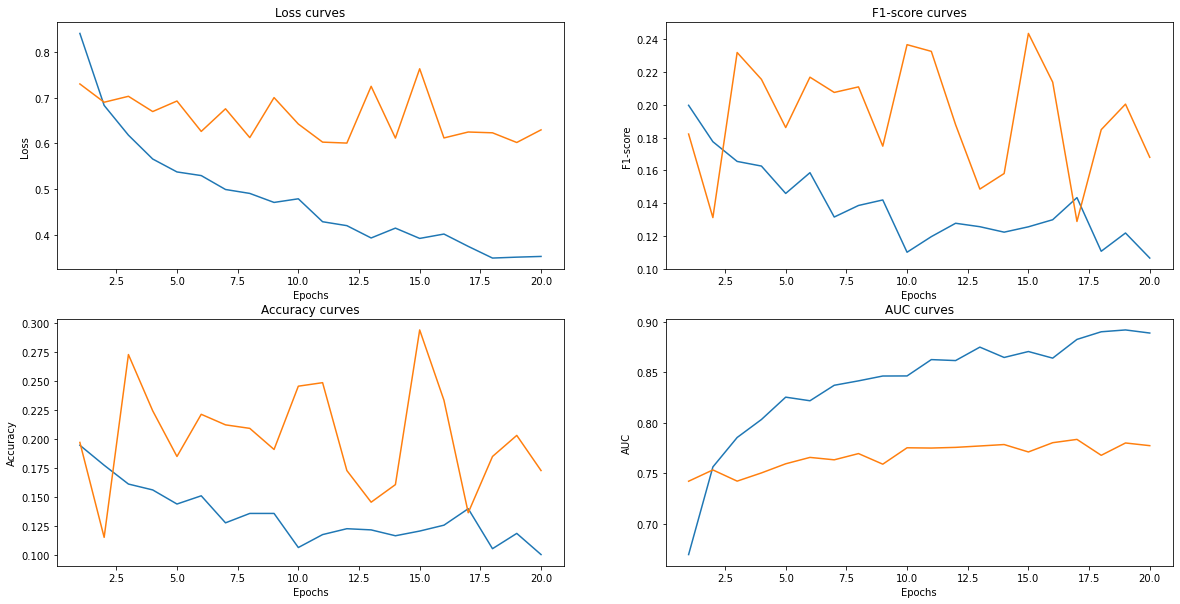

In [ ]:
# Plot loss and metric curves
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].plot(range(1, epochs + 1), train_losses, label = 'Training loss')
ax[0, 0].plot(range(1, epochs + 1), val_losses, label = 'Validation loss')
ax[0, 0].set_title('Loss curves')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')

ax[0, 1].plot(range(1, epochs + 1), train_f1s, label = 'Training F1-score')
ax[0, 1].plot(range(1, epochs + 1), val_f1s, label = 'Validation F1-score')
ax[0, 1].set_title('F1-score curves')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('F1-score')

ax[1, 0].plot(range(1, epochs + 1), train_accuracies, label = 'Training accuracy')
ax[1, 0].plot(range(1, epochs + 1), val_accuracies, label = 'Validation accuracy')
ax[1, 0].set_title('Accuracy curves')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Accuracy')

ax[1, 1].plot(range(1, epochs + 1), train_aucs, label = 'Training AUC')
ax[1, 1].plot(range(1, epochs + 1), val_aucs, label = 'Validation AUC')
ax[1, 1].set_title('AUC curves')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('AUC')

plt.show()

# Test

In [ ]:
# Sample batch
for i, (images,target) in enumerate(train_loader):
  images = images.to(device)
  target = target.to(device)
  break

print("Image batch shape:", images.shape)
print("Image tensor data type:", images[0].type())
print("Labels batch shape", target.shape)
print("Labels tensor data type", target[0].type)
print('Batch labels:', target)

Image batch shape: torch.Size([16, 3, 200, 140])
Image tensor data type: torch.cuda.FloatTensor
Labels batch shape torch.Size([16])
Labels tensor data type <built-in method type of Tensor object at 0x7ff37b24f3b0>
Batch labels: tensor([3, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 3, 2, 2], device='cuda:0')


In [ ]:
model.eval()
with torch.no_grad():
  output = model(images)
  output.shape

In [ ]:
output

tensor([[1.6281e-18, 1.0000e+00, 3.2583e-30, 6.0830e-22],
        [2.6671e-04, 9.9049e-01, 6.6711e-05, 9.1767e-03],
        [4.4593e-02, 1.2156e-08, 3.4550e-10, 9.5541e-01],
        [6.8298e-02, 9.2539e-01, 3.3762e-05, 6.2764e-03],
        [7.3175e-04, 9.9926e-01, 1.0813e-07, 1.2914e-05],
        [2.1385e-08, 1.0000e+00, 1.1930e-09, 9.7869e-08],
        [2.3310e-07, 9.9999e-01, 1.3535e-08, 5.2441e-06],
        [2.6229e-02, 9.7350e-01, 2.3204e-05, 2.4861e-04],
        [1.1889e-06, 1.0000e+00, 2.0548e-10, 6.1925e-08],
        [6.7974e-06, 9.9954e-01, 1.2820e-11, 4.5065e-04],
        [3.4883e-03, 9.9648e-01, 9.6386e-09, 3.6591e-05],
        [3.7709e-03, 9.9615e-01, 4.7359e-06, 7.5876e-05],
        [7.4778e-04, 9.9909e-01, 1.8403e-06, 1.5591e-04],
        [2.7202e-05, 9.9997e-01, 2.4497e-11, 4.8368e-06],
        [9.3546e-06, 9.9999e-01, 3.2909e-10, 2.5858e-07],
        [1.1075e-04, 9.9862e-01, 5.4909e-04, 7.2496e-04]], device='cuda:0')

In [ ]:
target

tensor([3, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 3, 2, 2], device='cuda:0')

In [ ]:
output.shape

torch.Size([16, 4])

In [ ]:
target.shape

torch.Size([16])

In [ ]:
loss = criterion(output, target)

In [ ]:
loss

tensor(11.3403, device='cuda:0')

In [ ]:
preds = torch.argmax(output, axis = -1) + 1

In [ ]:
preds

tensor([2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_whole = labels['label'].values
label_binarizer = LabelBinarizer().fit(y_whole)
y_onehot_pred = label_binarizer.transform(preds.cpu())

y_onehot_target = label_binarizer.transform(target.cpu())

In [ ]:
y_onehot_target.shape

(16, 4)

In [ ]:
import matplotlib.pyplot as plt

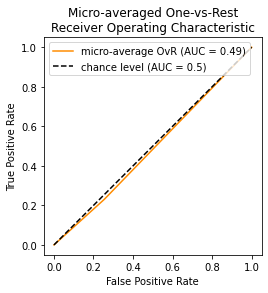

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_target.ravel(),
    y_onehot_pred.ravel(),
    name = "micro-average OvR",
    color = "darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    target.cpu().numpy(),
    output.cpu().numpy(),
    multi_class="ovr",
    average="weighted",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

ValueError: ignored

In [ ]:
micro_roc_auc_ovr

0.5357905982905984

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
f1_score(target.cpu(), preds.cpu(), average = 'weighted')

0.03125

In [ ]:
weights

tensor([2.3400, 1.0200, 1.0000, 1.1400], device='cuda:0')

In [ ]:
target

tensor([3, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 3, 2, 2], device='cuda:0')

In [ ]:
weighted_target = target * weights

RuntimeError: ignored

In [ ]:
np.mean((preds == target).cpu().numpy())

0.375

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(target.cpu(), preds.cpu())

0.375

In [ ]:
running_outputs = torch.empty(0).cuda()

In [ ]:
torch.cat([running_outputs, output]).shape

torch.Size([16, 4])

# My model 1

In [ ]:
train_losses = []
train_f1s = []

val_losses = []
val_f1s = []

def train_phase(train_loader, model, criterion, optimizer, num_epochs = 3):

  phase = 'train'

  model.train()
  dataset = train_dataset
  dataloader = train_loader

  running_loss = 0.0
  running_preds = torch.empty(0).cuda()
  running_labels = torch.empty(0).cuda()

  for inputs, targets in dataloader:
    inputs = inputs.cuda()
    targets = targets.cuda()

  outputs = model(inputs)
  outputs = outputs.squeeze()
  loss = criterion(outputs, targets)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  preds = torch.argmax(outputs, axis = -1) + 1
  running_preds = torch.cat([running_preds, preds])

  running_loss += loss.item() * inputs.size(0)
  running_labels = torch.cat([running_labels, targets])


def val_phase(model, criterion, optimizer, num_epochs = 3):

  phase = 'validation'

  model.eval()
  dataset = val_dataset
  dataloader = val_loader

  running_loss = 0.0
  running_preds = torch.empty(0).cuda()
  running_labels = torch.empty(0).cuda()


def train_model(model, criterion, optimizer, num_epochs = 3):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)







            epoch_loss = running_loss / len(dataset)
            epoch_f1 = f1_score(running_labels.cpu(), running_preds.cpu(), average = 'weighted')

            print('{} loss: {:.4f}, f1: {:.4f}'.format(phase, epoch_loss, epoch_f1))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_f1s.append(epoch_f1)
            else:
                val_losses.append(epoch_loss)
                val_f1s.append(epoch_f1)

            if phase == 'validation' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1 score: {best_f1:4f}')

    return model

In [ ]:
epochs = 5

model_trained_focal_loss = train_model(model, criterion, optimizer, num_epochs = epochs)

Epoch 1/5
----------


RuntimeError: ignored

# My model

In [ ]:
!pip install -qU braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 25.8 MB/s eta 0:00:00


In [ ]:
from braindecode.models import ShallowFBCSPNet
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  torch.backends.cudnn.benchmark = True

model = ShallowFBCSPNet(
    in_chans = 200,
    n_classes = 4,
    input_window_samples = 140,
    final_conv_length = "auto"
)

model = model.cuda()

ShallowFBCSPNet(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 200), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 4, kernel_size=(3, 1), stride=(1, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=squeeze_final_output) 
)

In [ ]:
import skorch

In [ ]:
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 4

clf = EEGClassifier(
    model,
    criterion = torch.nn.NLLLoss,
    optimizer = torch.optim.AdamW,
    train_split=,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
)

clf.fit(train_subset, y=None, epochs=n_epochs)

# score the Model after training (optional)
y_test = test_set.get_metadata().target
test_acc = clf.score(test_set, y=y_test)
print(f"Test acc: {(test_acc * 100):.2f}%")